In [1]:
import pandas as pd
import numpy as np

In [2]:
school_survey = pd.read_csv('data/36423-0001-Data.tsv',sep='\t')
student_survey = pd.read_csv('data/36423-0002-Data.tsv',sep='\t')

X2UNIV2A: X2 Base year status and how sample member entered F1 sample

Indicates the base year status (respondent, non-respondent, questionnaire ineligible) for base year sample members.

Base year respondent = 1

In [3]:
check1 = student_survey['X2UNIV2A'].value_counts()
check1

1    21444
2     2059
Name: X2UNIV2A, dtype: int64

In [4]:
filter1 = student_survey[student_survey['X2UNIV2A'] == 1]

Yay! From paper, we have first repeated result:

"HSLS:09 began with a nationally rep- resentative sample of ninth graders in fall 2009 (21,444 students from 944 schools) and followed them through postsecondary edu- cation."

Now we need to check for *first time* 9th graders, as per Appendix A

This is the relevant variable: S1GRD0809, "S1 B01 Grade 9th grader was in last year (2008-09)"

1 7th Grade 64 0.3 %

2 8th Grade 20178 85.9 %

3 9th Grade 1124 4.8 %

4 In an ungraded program 61 0.3 %

In [5]:
filter1 = filter1[(filter1['S1GRD0809'] != 3) & (filter1['S1GRD0809'] != 4) & (filter1['S1GRD0809'] > 0)]
len(filter1)

20242

## YES
This took a lot of trial and error to nail down, but finally the figure is correct!!

**From paper:**

"Our analytic sample is restricted to first-time 9th-graders, whose information on their career aspirations is available in at least one of the two survey rounds (n = 20,242)."

## NOTE ON STEM ASPIRATIONS
Stem aspirations is "dichotomous" variable as the authors note. My best guess is that they mean that either *X1STU30OCC_STEM1* or *X2STU30OCC_STEM1* is 1 for an individual. I add this variable here.

In [50]:
filter1['stem_career_aspirations'] = ((filter1['X1STU30OCC_STEM1'] == 1) | (filter1['X2STU30OCC_STEM1'] == 1)).astype(np.int8)
filter1['stem_career_aspirations'].value_counts()

0    17451
1     2791
Name: stem_career_aspirations, dtype: int64

#### Constructing demographic columns
They also do some reconstructing of demographic columns.

Sex

In [51]:
filter1['sex'] = filter1['X1SEX']
filter1['sex'] = filter1['sex'].astype('category')

In [78]:
sex_map = {
    1: "boys",
    2: "girls"
}

Race:

1	Amer. Indian/Alaska Native, non-Hispanic	165	0.70

2	Asian, non-Hispanic	1,952	8.31

3	Black/African-American, non-Hispanic	2,450	10.42

4	Hispanic, no race specified	422	1.80

5	Hispanic, race specified	3,375	14.36

6	More than one race, non-Hispanic	1,941	8.26

7	Native Hawaiian/Pacific Islander, non-Hispanic	110	0.47

8	White, non-Hispanic	12,082	51.41

-9	Missing	1,006	4.28

In [52]:
filter1['race'] = filter1['X1RACE']
filter1.loc[filter1["race"] == 8, "race"] = 11
filter1.loc[filter1["race"] == 3, "race"] = 12
filter1.loc[filter1["race"] == 4, "race"] = 13
filter1.loc[filter1["race"] == 5, "race"] = 13
filter1.loc[filter1["race"] == 2, "race"] = 14
filter1.loc[filter1["race"] == 6, "race"] = 15
filter1.loc[filter1["race"] == 7, "race"] = 16
filter1.loc[filter1["race"] == 1, "race"] = 16
filter1['race'] = filter1['race'] - 10
filter1['race'] = filter1['race'].astype('category')
filter1['race'].value_counts()

1    11332
3     3282
2     1985
5     1802
4     1591
6      250
Name: race, dtype: int64

In [79]:
race_map = {
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "Multiracial",
    6: "Other"
}

SES (Socio-economic Status)

Possible Variables:
X4X2SES_U

In [53]:
filter1['SES'] = pd.qcut(filter1['X1SES_U'],4,labels=np.arange(4) + 1)
filter1['SES'] = filter1['SES'].astype('category')
filter1['SES'].value_counts()

1    5063
3    5061
4    5060
2    5058
Name: SES, dtype: int64

In [54]:
filter1['HigherSES'] = (filter1['SES'] > 2).astype(int)
filter1['HigherSES'] = filter1['HigherSES'].astype('category')
filter1['HigherSES'].value_counts()

0    10121
1    10121
Name: HigherSES, dtype: int64

In [80]:
hSES_map = {
    0: "lower-SES",
    1: "higher-SES"
}

## Now going into STEM findings
Relevant variable here is: X1STU30OCC_STEM1: X1 Student occupation at age 30: STEM code 1 (sub-domain) (I believe this is from 9th grade?)

0	Not a STEM occupation	13,969	59.43

1	Life and Physical Science, Engineering, Mathematics, and Information Technology Occupations	1,726	7.34

4	Health Occupations	4,351	18.51

5	Split across 2 sub-domains	413	1.76

6	Unspecified sub-domain	301	1.28

9	Uncodeable	258	1.10

-9	Missing	426	1.81

-8	Unit non-response	2,059	8.76

As there is also:

X2STU30OCC_STEM1: X2 Student occupation at age 30: STEM code 1 (sub-domain)

0	Not a STEM occupation	12,991	55.27

1	Life and Physical Science, Engineering, Mathematics, and Information Technology Occupations	1,878	7.99

4	Health Occupations	4,619	19.65

5	Split across 2 sub-domains	601	2.56

6	Unspecified sub-domain	55	0.23

9	Uncodeable	96	0.41

-9	Missing	354	1.51

-8	Unit non-response	2,909	12.38

## Let's check Table B1
This is the product of the linear model they ran. Simple n counts to start! 

In [55]:
stem_round_one = filter1[filter1['X1STU30OCC_STEM1'].isin([0,1,2,3,4,5,6])]
len(stem_round_one)

19633

Correct! Table B1 reports "n=19633" for 9th grade first round

In [56]:
stem_round_two = filter1[filter1['X2STU30OCC_STEM1'].isin([0,1,2,3,4,5,6])]
len(stem_round_two)

17421

Also correct, number of eleventh graders

There are two other sets of individuals reported on, "Persisters" and "Emergers". Persisters had stem interest in both ninth and eleventh grade, while emergers are the subset of students who reported no stem interest in ninth grade, but reported interest in eleventh grade.

In order to properly do this, we are going to actually create our sets of individuals for ninth grade, eleventh, persisters and emergers.

**UGH** Please define your terms! Are persisters individuals who maintained the same categorization for STEM interest, or any interest?? 

Ok, it appears that the authors had access to the private version of the study, which has some uncoded individuals for privacy concerns (haha). So, the overall numbers will be a bit off, but not by much. Enough for me to proceed, I believe.

In [57]:
ninth_grade = stem_round_one
eleventh_grade = stem_round_two

In [58]:
# Find persisters
persisters_set = filter1[filter1['X1STU30OCC_STEM1'].isin([1,2,3])]
persisters = persisters_set[persisters_set['X2STU30OCC_STEM1'].isin([1,2,3])]
print(len(persisters_set))
print(len(persisters)/len(persisters_set))

non_persisters = persisters_set[~persisters_set['X2STU30OCC_STEM1'].isin([1,2,3])]
len(non_persisters)


1667
0.3311337732453509


1115

Good, the 1667 number is lower than the reported total in the Table B1 (n=1988), but this is likely due to a coding issue. The actual percentage of persisters (33.1) is nearly identical to the paper finding of 34.3. 

In [59]:
# Find emergers
emergers_set = filter1[~filter1['X1STU30OCC_STEM1'].isin([1,2,3])]
emergers = emergers_set[emergers_set['X2STU30OCC_STEM1'].isin([1,2,3])]
print(len(emergers_set))
print(len(emergers))
print(len(emergers)/len(emergers_set))

18575
1124
0.0605114401076716


Percentage of emergers at 6.1% is also about the same as (6.9% in the paper)!

Absolute number of non-persistors versus emergers are also similar (1115 ≈ 1124), as is also stated in the paper.

In [60]:
sets = [ninth_grade, eleventh_grade, persisters_set, emergers_set]

In [61]:
X_cols = ['sex','race','HigherSES']

In [62]:
dependent_var = 'stem_career_aspirations'

### Checking some percentages

Replication Figure 2.

In [91]:
set_map = {}
for i, s in enumerate(sets):
    percent_map = {}
    for val1 in s['race'].unique():
        for val2 in s['sex'].unique():
            for val3 in s['HigherSES'].unique():
                temp = s[(s['race'] == val1) & (s['HigherSES'] == val3) & (s['sex'] == val2)]
                interested = temp[temp[dependent_var] == 1]
                percent_map[race_map[val1] + ',' 
                          + hSES_map[val3] + ' '
                          + sex_map[val2]] = len(interested)/len(temp)
    set_map[i] = percent_map


[Text(0, 0, '23.65'),
 Text(0, 0, '18.03'),
 Text(0, 0, '9.08'),
 Text(0, 0, '7.99'),
 Text(0, 0, '20.26'),
 Text(0, 0, '13.6'),
 Text(0, 0, '9.57'),
 Text(0, 0, '4.56'),
 Text(0, 0, '19.35'),
 Text(0, 0, '12.2'),
 Text(0, 0, '10.84'),
 Text(0, 0, '7.2'),
 Text(0, 0, '22.38'),
 Text(0, 0, '22.81'),
 Text(0, 0, '8.42'),
 Text(0, 0, '8.24'),
 Text(0, 0, '22.8'),
 Text(0, 0, '16.16'),
 Text(0, 0, '11.82'),
 Text(0, 0, '9.21'),
 Text(0, 0, '19.23'),
 Text(0, 0, '11.11'),
 Text(0, 0, '14.89'),
 Text(0, 0, '7.25')]

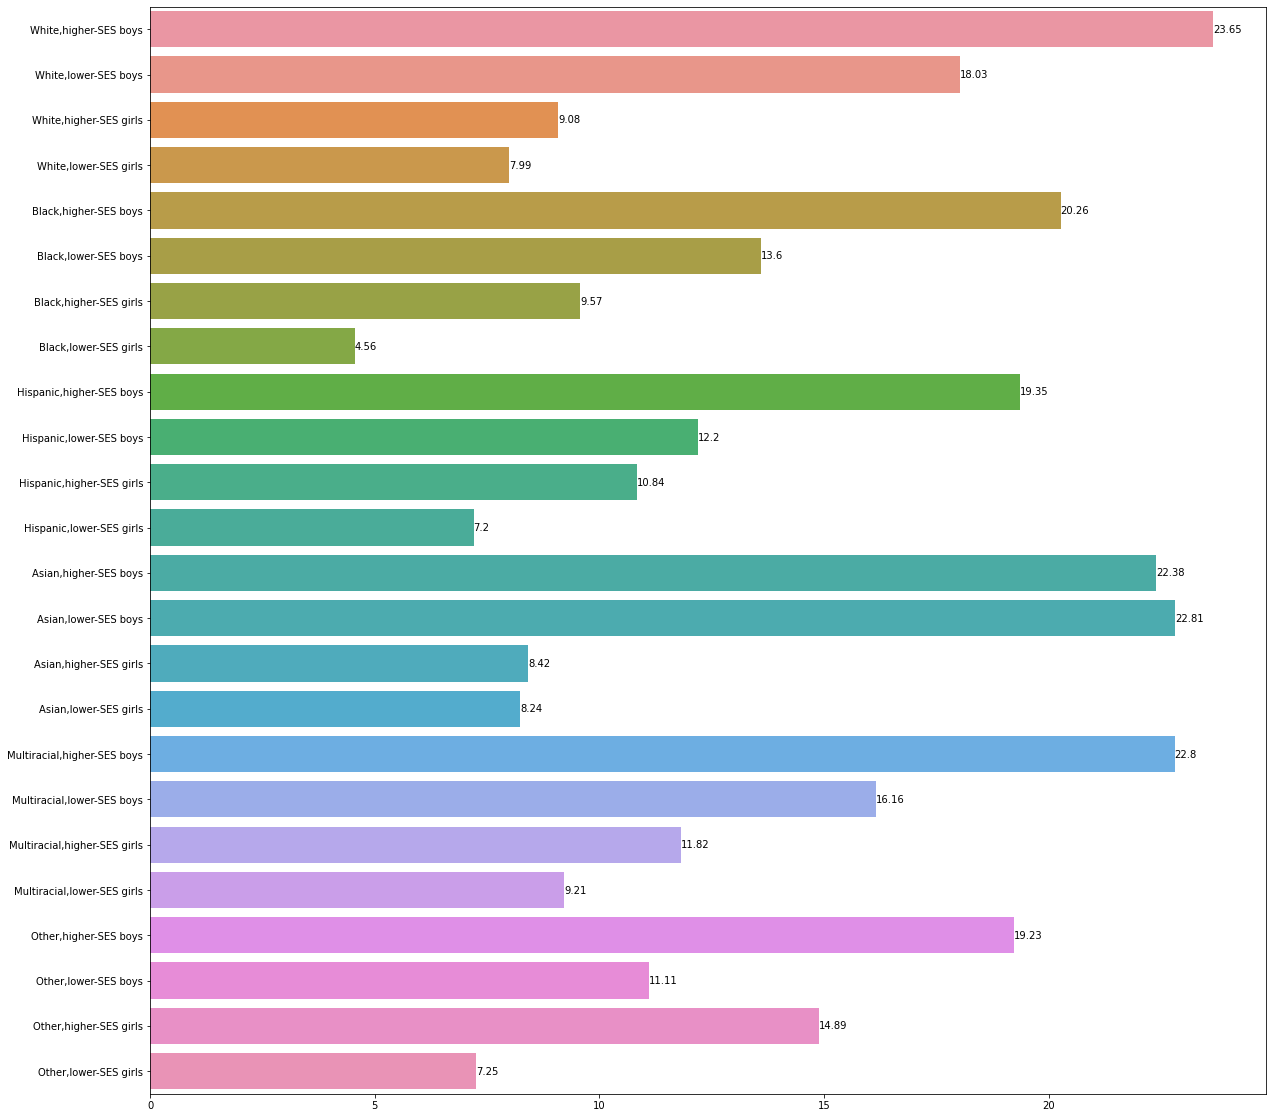

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns
labels = list(set_map[0].keys())
values = list(set_map[0].values())
values = [round((v * 100), 2) for v in values]

plt.figure(figsize=(20,20))
ax = sns.barplot(x=values, y=labels, orient='h')
ax.bar_label(ax.containers[0])

### Fully replicating Table B1

In [314]:
X_cols = ['X1SEX']

In [324]:
pd.get_dummies(ninth_grade['X1SEX'],prefix='X1SEX')

,X1SEX_1,X1SEX_2
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
23497,1,0
23498,0,1
23499,0,1
23500,0,1


In [325]:
import statsmodels.api as sm

for set in sets:
    for x in X_cols:
        x_vars = pd.get_dummies(set[x],prefix=x)
        model = sm.WLS(set[dependent_var], x_vars, weights=set['W1STUDENT'])
        result = model.fit()
        print(result.summary())
        print(result.params)

                               WLS Regression Results                              
Dep. Variable:     stem_career_aspirations   R-squared:                       0.023
Model:                                 WLS   Adj. R-squared:                  0.023
Method:                      Least Squares   F-statistic:                     454.1
Date:                     Thu, 14 Jul 2022   Prob (F-statistic):           1.24e-99
Time:                             13:57:46   Log-Likelihood:                -11309.
No. Observations:                    19633   AIC:                         2.262e+04
Df Residuals:                        19631   BIC:                         2.264e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1

/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


You will need it for your career

https://nces.ed.gov/OnlineCodebook/Session/Codebook/eb8b7629-b168-4d01-8cd6-c5d31a874104